## Cat.png layer visualization

Uses train function instead of implementing training outside of definitions. 
- Pro: clean code, only one line, saves progress when keyboard interrupt.
- Con: can only implement train once, somehow second calls give error "tf.function-decorated function tried to create variables on non-first call"
- Con: cannot do continuous training

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

#### Image processing

In [2]:
# Load image and limits dimensions to 512, outputs tf tensor

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [3]:
# display tf tensor as an image

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

#### Modified VGG19 Model

In [4]:
# Creates a vgg model that returns a list of intermediate output values

def vgg_layers(layer_names):
    # paper uses avg pooling, exclude fully connected layers since no predictions
    vgg = VGG19(weights='imagenet', include_top=False, pooling = 'avg')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

#### Visualization training

In [5]:
# Image pixel values are from 0 to 1 so define a function that clips value to this range

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [6]:
def visualization_loss(outputs,targets):
    return tf.reduce_mean((outputs-targets)**2)

In [7]:
@tf.function()
def train_step(visualization, new_model, targets, opt):
    opt = opt
    with tf.GradientTape() as tape:
        outputs = new_model(visualization)
        loss = visualization_loss(outputs,targets)

    grad = tape.gradient(loss, visualization)
    opt.apply_gradients([(grad, visualization)])
    visualization.assign(clip_0_1(visualization))
    
    return loss

In [8]:
# create randomly intialized image, which would be trained on to revisualize the designated layer
# shape matches the content_image
# return tensor Variable

def initialization(img_shape, seed = 0):
    random = tf.random.Generator.from_seed(seed) # an instance of the generator class
    random_init = random.uniform(minval=0, maxval=1, shape=img_shape) 
    tensor_to_image(random_init)
    visualization = tf.Variable(random_init)
    
    return visualization

In [9]:
# layers(list): choose which layers's output are used

def train(img_path, layers, learning_rate = 1, loss_threshold = 0.01):
    
    try:
        img = load_img(img_path)   # Load image as tensor

        new_model = vgg_layers(layers)   # new model that returns intermediate output of specified layers
        targets = new_model(tf.constant(img))   # Target output based on the original image
    
        visualization = initialization(img.shape)   #initialize tensor Variable for training

        opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=0.99, epsilon=1e-1)
        loss = train_step(visualization, new_model, targets, opt)
    
        # train
        step = 0
        loss_list = []
        while loss > loss_threshold:
            loss = train_step(visualization, new_model, targets, opt)
            loss_list.append(loss.numpy())
            step += 1
        
            # print progress every 100 steps
            if step % 100 == 0:
                print(f'{step}: {loss.numpy()}')
            
        return visualization, loss_list, step
    
    except KeyboardInterrupt:
        
        print("KeyboardInterrupt")
        return visualization, loss_list, step

## Implementation cat.jpg

#### block5_conv1

In [10]:
layers = ['block5_conv1']
visualization, loss_list, step = train('cat.jpg', layers)

2022-01-27 11:58:17.725682: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-27 11:58:19.148739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


100: 2.2374367713928223
200: 1.6018861532211304
300: 1.1987992525100708
400: 0.9547975659370422
500: 0.7875159978866577
600: 0.6659706830978394
700: 0.5725539326667786
800: 0.4978944659233093
900: 0.4386242926120758
1000: 0.3906766474246979
1100: 0.3507344126701355
1200: 0.31722164154052734
1300: 0.2887526750564575
1400: 0.2644627094268799
1500: 0.24361488223075867
1600: 0.22558598220348358
1700: 0.2096610814332962
1800: 0.19592563807964325
1900: 0.18403390049934387
2000: 0.17343828082084656
2100: 0.16391654312610626
2200: 0.15543128550052643
2300: 0.1478540599346161
2400: 0.1411622166633606
2500: 0.13497968018054962
2600: 0.1293204128742218
2700: 0.12403436750173569
2800: 0.11923746764659882
2900: 0.11481592804193497
3000: 0.1107960194349289
3100: 0.10711642354726791
3200: 0.10368553549051285
3300: 0.10048351436853409
3400: 0.0974888950586319
3500: 0.0946684405207634
3600: 0.09201162308454514
3700: 0.08951304107904434
3800: 0.08714349567890167
3900: 0.08489256352186203
4000: 0.0827856

30500: 0.012105414643883705
30600: 0.012069293297827244
30700: 0.012033527716994286
30800: 0.011997686699032784
30900: 0.011962249875068665
31000: 0.011926993727684021
31100: 0.011892072856426239
31200: 0.011856770142912865
31300: 0.011821608059108257
31400: 0.011786732822656631
31500: 0.011752726510167122
31600: 0.011719398200511932
31700: 0.011686356738209724
31800: 0.011653231456875801
31900: 0.011620257049798965
32000: 0.011588181369006634
32100: 0.011556489393115044
32200: 0.011524773202836514
32300: 0.011493142694234848
32400: 0.01146196760237217
32500: 0.011431003920733929
32600: 0.011400258168578148
32700: 0.011369876563549042
32800: 0.011339952237904072
32900: 0.011310256086289883
33000: 0.011280564591288567
33100: 0.01124864723533392
33200: 0.011216464452445507
33300: 0.011185445822775364
33400: 0.011155232787132263
33500: 0.011125361546874046
33600: 0.011095811612904072
33700: 0.011066718026995659
33800: 0.0110379783436656
33900: 0.011009486392140388
34000: 0.010981095023453

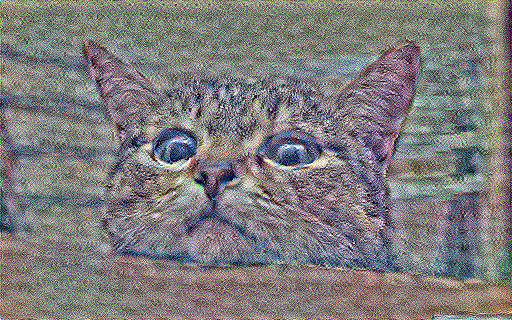

In [11]:
tensor_to_image(visualization)

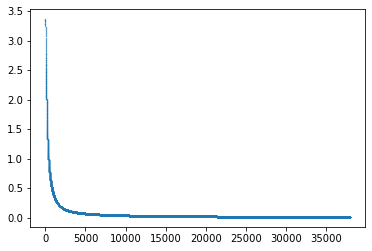

In [12]:
# Visualize loss
plt.scatter(np.arange(step)+1, loss_list, s=0.1)
plt.show()

#### block5_conv2

In [10]:
layers = ['block5_conv2']
visualization, loss_list, step = train('cat.jpg', layers)

2022-01-26 12:46:48.112088: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-26 12:46:49.626670: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


100: 0.5999850034713745
200: 0.5284394025802612
300: 0.4802694320678711
400: 0.4364347457885742
500: 0.3871503472328186
600: 0.3325278162956238
700: 0.2837649881839752
800: 0.24853730201721191
900: 0.2213796079158783
1000: 0.19887930154800415
1100: 0.17823536694049835
1200: 0.16209842264652252
1300: 0.149062842130661
1400: 0.138515442609787
1500: 0.1294812709093094
1600: 0.12159247696399689
1700: 0.11467130482196808
1800: 0.10863655805587769
1900: 0.10324792563915253
2000: 0.09837248921394348
2100: 0.09400089830160141
2200: 0.09010802209377289
2300: 0.08661206811666489
2400: 0.0834227055311203
2500: 0.08046193420886993
2600: 0.07775253802537918
2700: 0.07526463270187378
2800: 0.07297313213348389
2900: 0.070876844227314
3000: 0.0689150020480156
3100: 0.0670742318034172
3200: 0.06533661484718323
3300: 0.06369533389806747
3400: 0.06212657690048218
3500: 0.060613930225372314
3600: 0.059178389608860016
3700: 0.0578276589512825
3800: 0.05654238536953926
3900: 0.05529266595840454
4000: 0.0540

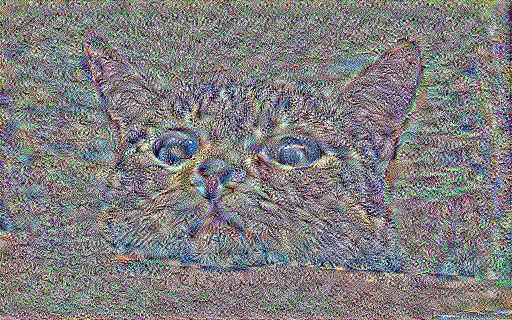

In [11]:
tensor_to_image(visualization)

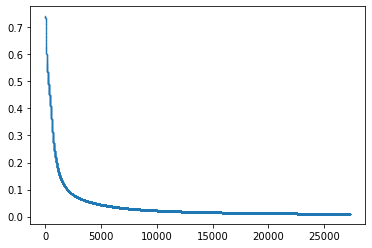

In [12]:
# Visualize loss
plt.scatter(np.arange(step)+1, loss_list, s=0.1)
plt.show()

#### block5_conv3

In [10]:
layers3 = ['block5_conv3']
visualization3, loss_list3, step3 = train('cat.jpg', layers3, learning_rate = 1, loss_threshold = 0.04)

2022-01-25 19:05:03.907344: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-25 19:05:05.429982: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


100: 0.19284920394420624
200: 0.17433032393455505
300: 0.1596495807170868
400: 0.14909400045871735
500: 0.14125224947929382
600: 0.13493545353412628
700: 0.12946347892284393
800: 0.12448686361312866
900: 0.11972538381814957
1000: 0.11511407792568207
1100: 0.1103595718741417
1200: 0.1055522933602333
1300: 0.10045565664768219
1400: 0.0946442186832428
1500: 0.0882018581032753
1600: 0.08208365738391876
1700: 0.0772114098072052
1800: 0.0732414647936821
1900: 0.06981171667575836
2000: 0.06663016974925995
2100: 0.06345131248235703
2200: 0.060379575937986374
2300: 0.057425178587436676
2400: 0.0546136200428009
2500: 0.05194082856178284
2600: 0.049362387508153915
2700: 0.04696512594819069
2800: 0.044752586632966995
2900: 0.042743247002363205
3000: 0.040887560695409775


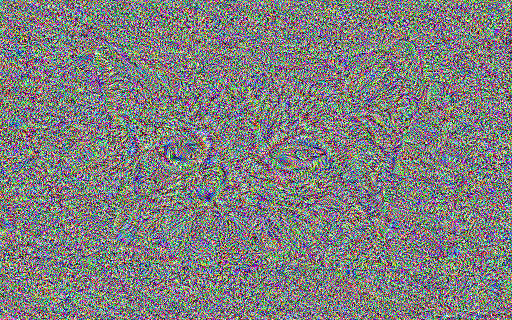

In [11]:
tensor_to_image(visualization3)

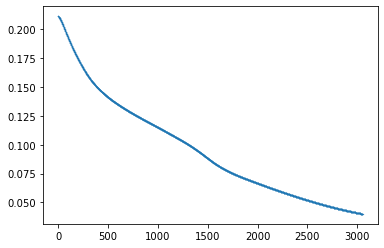

In [14]:
# Visualize loss
plt.scatter(np.arange(step3)+1, loss_list3, s=0.1)
plt.show()

In [10]:
layers3 = ['block5_conv3']
visualization3, loss_list3, step3 = train('cat.jpg', layers3, learning_rate = 1, loss_threshold = 0.01)

2022-01-26 00:10:54.113602: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-26 00:10:55.542527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


100: 0.19284920394420624
200: 0.17433032393455505
300: 0.1596495807170868
400: 0.14909400045871735
500: 0.14125224947929382
600: 0.13493545353412628
700: 0.12946347892284393
800: 0.12448686361312866
900: 0.11972538381814957
1000: 0.11511407792568207
1100: 0.1103595718741417
1200: 0.1055522933602333
1300: 0.10045565664768219
1400: 0.0946442186832428
1500: 0.0882018581032753
1600: 0.08208365738391876
1700: 0.0772114098072052
1800: 0.0732414647936821
1900: 0.06981171667575836
2000: 0.06663016974925995
2100: 0.06345131248235703
2200: 0.060379575937986374
2300: 0.057425178587436676
2400: 0.0546136200428009
2500: 0.05194082856178284
2600: 0.049362387508153915
2700: 0.04696512594819069
2800: 0.044752586632966995
2900: 0.042743247002363205
3000: 0.040887560695409775
3100: 0.039235420525074005
3200: 0.03779018670320511
3300: 0.03654410317540169
3400: 0.03543296083807945
3500: 0.03441386669874191
3600: 0.03347513824701309
3700: 0.032597944140434265
3800: 0.03176622837781906
3900: 0.0309858955442

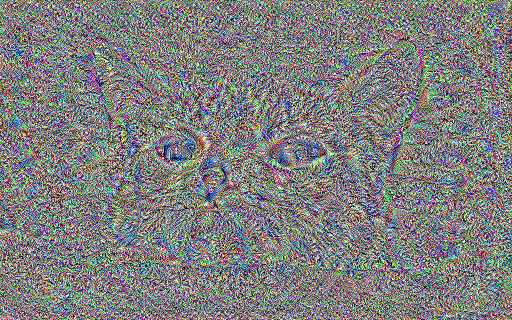

In [11]:
tensor_to_image(visualization3)

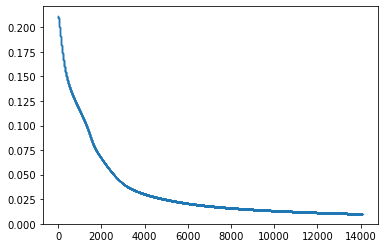

In [12]:
# Visualize loss
plt.scatter(np.arange(step3)+1, loss_list3, s=0.1)
plt.show()

#### block4_conv3

In [11]:
layers4 = ['block4_conv3']
visualization4, loss_list4, step4 = train('cat.jpg', layers4)

2022-01-26 09:36:10.049770: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-26 09:36:11.391314: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


100: 17.10279655456543
200: 10.660795211791992
300: 7.2319464683532715
400: 5.049360752105713
500: 3.53745698928833
600: 2.435720443725586
700: 1.6905968189239502
800: 1.1996828317642212
900: 0.8678686022758484
1000: 0.6317119598388672
1100: 0.46025198698043823
1200: 0.3276851773262024
1300: 0.23204350471496582
1400: 0.16916103661060333
1500: 0.12942203879356384
1600: 0.1038435846567154
1700: 0.08715139329433441
1800: 0.07556228339672089
1900: 0.06699008494615555
2000: 0.060400914400815964
2100: 0.055155567824840546
2200: 0.05088646337389946
2300: 0.047337524592876434
2400: 0.0443182997405529
2500: 0.04169612005352974
2600: 0.039401598274707794
2700: 0.03738918900489807
2800: 0.0356149785220623
2900: 0.034038085490465164
3000: 0.03261641412973404
3100: 0.031332168728113174
3200: 0.03016890212893486
3300: 0.029101237654685974
3400: 0.028110763058066368
3500: 0.027189895510673523
3600: 0.02633671835064888
3700: 0.025540539994835854
3800: 0.024798830971121788
3900: 0.024104060605168343
40

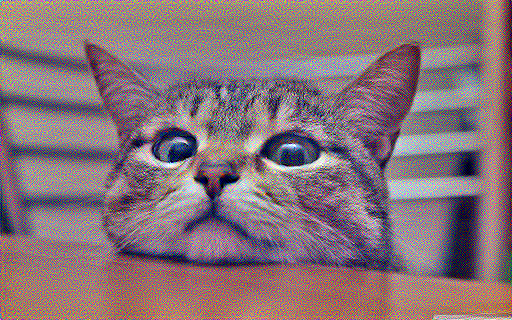

In [12]:
tensor_to_image(visualization4)

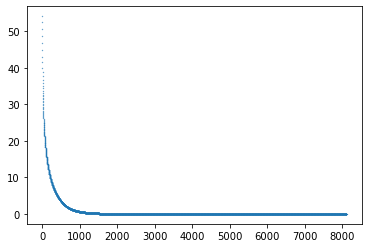

In [13]:
# Visualize loss
plt.scatter(np.arange(step4)+1, loss_list4, s=0.1)
plt.show()

#### block3_conv3

In [10]:
layers = ['block3_conv3']
visualization, loss_list, step = train('cat.jpg', layers)

2022-01-25 15:16:57.670914: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-25 15:16:59.005063: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


100: 15.736150741577148
200: 8.51949691772461
300: 4.568935394287109
400: 2.4119720458984375
500: 1.1291736364364624
600: 0.5890876054763794
700: 0.37002256512641907
800: 0.26549050211906433
900: 0.20782127976417542
1000: 0.173105388879776
1100: 0.15007732808589935
1200: 0.1336422711610794
1300: 0.12132833153009415
1400: 0.1118619441986084
1500: 0.104214608669281
1600: 0.0977156013250351
1700: 0.09208550304174423
1800: 0.08714155107736588
1900: 0.08276968449354172
2000: 0.07882905006408691
2100: 0.07522813975811005
2200: 0.07195884734392166
2300: 0.06900971382856369
2400: 0.06634772568941116
2500: 0.06393472850322723
2600: 0.06173758953809738
2700: 0.05970942974090576
2800: 0.057818662375211716
2900: 0.05605664104223251
3000: 0.054413191974163055
3100: 0.05287199094891548
3200: 0.051397521048784256
3300: 0.049974821507930756
3400: 0.04863316938281059
3500: 0.04736161231994629
3600: 0.046161308884620667
3700: 0.04497472941875458
3800: 0.04376668110489845
3900: 0.042522601783275604
4000:

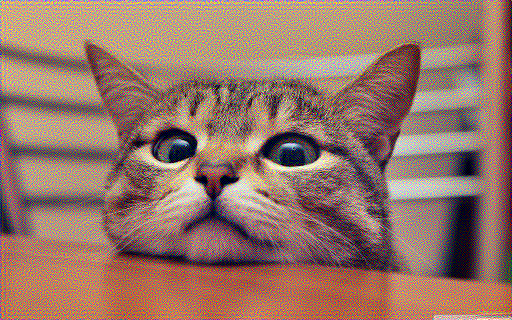

In [11]:
# Display the reconstruction
tensor_to_image(visualization)

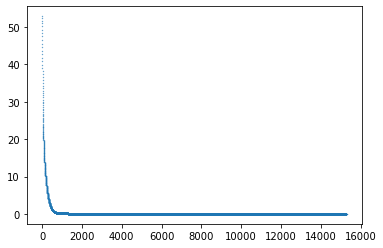

In [12]:
# Visualize loss
plt.scatter(np.arange(step)+1, loss_list, s=0.1)
plt.show()

#### block1_conv1

In [25]:
layers = ['block1_conv1']
visualization, loss_list, step = train('cat.jpg', layers)

2022-01-24 22:03:25.269879: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


100: 0.11474701017141342
200: 0.11411670595407486
300: 0.11332418024539948
400: 0.11241360753774643
500: 0.1114121675491333
600: 0.1103389710187912
700: 0.10920844972133636
800: 0.10803201049566269
900: 0.1068190336227417
1000: 0.10557718575000763
1100: 0.10431282222270966
1200: 0.1030314713716507
1300: 0.10173793882131577
1400: 0.10043623298406601
1500: 0.09912987053394318
1600: 0.09782178699970245
1700: 0.09651456773281097
1800: 0.09521065652370453
1900: 0.09391177445650101
2000: 0.09261979907751083
2100: 0.09133618324995041
2200: 0.09006229788064957
2300: 0.08879923820495605
2400: 0.0875481367111206
2500: 0.08630969375371933
2600: 0.08508466184139252
2700: 0.08387374877929688
2800: 0.08267764747142792
2900: 0.08149666339159012
3000: 0.08033111691474915
3100: 0.07918146252632141
3200: 0.07804803550243378
3300: 0.07693096995353699
3400: 0.07583042979240417
3500: 0.07474640756845474
3600: 0.07367902994155884
3700: 0.072628453373909
3800: 0.0715947225689888
3900: 0.07057783752679825
400

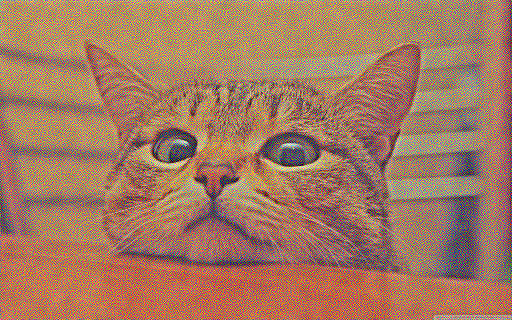

In [26]:
# Display the reconstruction
tensor_to_image(visualization)

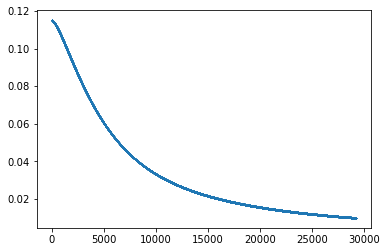

In [32]:
# Visualize loss
plt.scatter(np.arange(step)+1, loss_list, s=0.1)
plt.show()